<a href="https://colab.research.google.com/github/peterbmob/CH-PFC/blob/main/CH_spectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq

# plotting defaults
plt.rcParams['figure.dpi'] = 120
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
# ---- Physical constants ----
R = 8.3145                # J/mol//rotation.
E_base = 125.7e9       # Pa (Young's modulus)
nu_base = 0.252           # Poisson's ratio

# Eigenstrain (FP relative to LFP) — use 2D components; LFP reference at c=1, so ε^0(c) = (1-c) * ε*.
# (Table 1: 5.0%, 3.6%, -1.9% for principal directions; we take x,y = first two.)
# Eigenstrain (FP relative to LFP) with corrected values
eps_star_xx = 0.0165      # lattice mismatch along [100]K
T = 298.0                 # K
F = 96485.33212           # C/mol
NA = 6.02214076e23        # 1/mol

# ---- Material & model parameters (Hamadi et al., Table 1) ----
Vm = 4.38e-5              # m^3/mol (molar volume)
D  = 1e-15                # m^2/s (Li diffusivity in solid)
kappa = 1.68e-16         # J/m (gradient energy coefficient)
M0 = D*Vm/(R*T)           # mobility pre-factor for M = M0*c(1-c)

# Elasticity (homogeneous, plane strain). Base isotropic values; we allow anisotropy via scaling
eps_star_yy = 0.0036      # lattice mismatch along [010]
# eps_star_zz = -0.02     # [001] not used in 2D model
# shear eigenstrain set to 0 in crystal frame

# Anisotropy controls (2D orthotropic in plane)
# If anisotropy_scale_x != anisotropy_scale_y, stiffness differs along x/y.
anisotropy_scale_x = 1.0
anisotropy_scale_y = 1.0
# crystal orientation (radians): rotate both stiffness and eigenstrain from crystal -> lab
crystal_theta = 0 #np.pi/6

# ---- Kinetics ----
alpha = 0.5               # BV transfer coefficient
L_if = 1e-9               # m (interfacial width/length scale)

# Rate constants -> exchange current density via j0 = n F NA L^2 k
k_rate_BV  = 2.035e-4*1e5    # s^-1
k_rate_MHC = 2.062e-4     # s^-1
j0_BV  = 1.0*F*NA*(L_if**2)*k_rate_BV
j0_MHC = 1.0*F*NA*(L_if**2)*k_rate_MHC
lambda_MHC = 8.3*R*T      # J/mol (reorganization energy)
s_corr = 0.0              # optional small offset to match BV at low |η|

# Applied potential (cell voltage - OCV)
DeltaPhi = 0.2            # V

# ---- Free-energy model switches (from your FE analysis note) ----
fe_model = 'regular'      # 'regular' | 'cluster1' | 'cluster2'
omega   = 12e3            # J/mol (regular-solution interaction)
# one-dip parameters
alpha1  = 1.1e3           # J/mol
y1      = 0.62
w1      = 0.05
# second dip (dopant-scaled)
Cdop    = 0.10
alpha2  = 4.0e3           # J/mol
y2      = 0.60
w2      = 0.03

# ---- Numerical domain ----
nx, ny = 196, 196
Lx = Ly = 100e-9          # m (≈ 1 nm spacing)
dx = Lx/nx; dy = Ly/ny
x = np.arange(nx)*dx
y = np.arange(ny)*dy
X, Y = np.meshgrid(x, y, indexing='ij')

kx = 2*np.pi*fftfreq(nx, d=dx)
ky = 2*np.pi*fftfreq(ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0,0] = 1e-30
Kstack = np.stack((KX, KY), axis=-1)   # (..., 2)

# time stepping
dx = Lx/nx; dy = Ly/ny
CFL = 0.001  # Safety factor for stability (try 0.1 to 0.5)
dt = CFL * dx**2 / D
print(f"Using dt = {dt:.2e} s based on dx={dx:.2e} m and D={D:.2e} m^2/s")
#dt = 1e-12
nsteps = 15000
nplot = 1500
tol = 0.4
# choose kinetics
kinetics = 'BV'           # 'BV' or 'MHC'

# Add underrelaxation for numerical stability
omega_newton = 0.5      # Stronger underrelaxation (was 0.5)
max_newton = 30        # More iterations allowed (was 10)


Using dt = 2.60e-07 s based on dx=5.10e-10 m and D=1.00e-15 m^2/s


[FE:regular] mu_eq ≈ 9.3752e+05 J/m^3; coexistence c1≈0.992, c2≈0.992


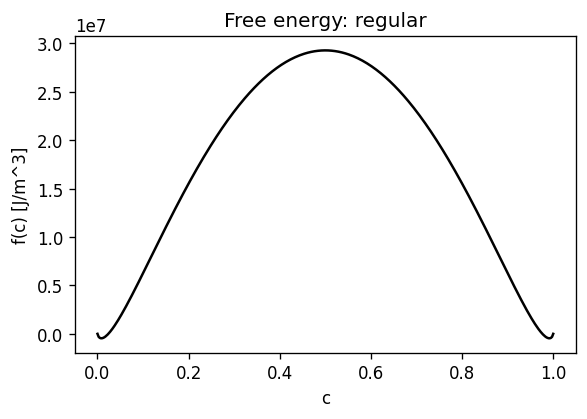

In [3]:
# ------------------ Free-energy functional ------------------
class FreeEnergy:
    def __init__(self, model, R, T, Vm, omega, alpha1, y1, w1, Cdop, alpha2, y2, w2):
        self.model = model
        self.R, self.T, self.Vm = R, T, Vm
        self.omega_ = omega / Vm
        self.alpha1_ = alpha1 / Vm
        self.alpha2_ = alpha2 / Vm
        self.y1, self.w1 = y1, max(w1, 1e-6)
        self.y2, self.w2 = y2, max(w2, 1e-6)
        self.Cdop = Cdop
        self.eps = 1e-12
    def f(self, c):
        ce = np.clip(c, self.eps, 1 - self.eps)
        ideal = (self.R*self.T/self.Vm) * (ce*np.log(ce) + (1-ce)*np.log(1-ce))
        rs    = self.omega_ * ce*(1 - ce)
        f = ideal + rs
        if self.model in ('cluster1','cluster2'):
            g1 = np.exp(- (ce - self.y1)**2 / (2*self.w1**2))
            f -= self.alpha1_ * ce*(1-ce) * g1
        if self.model == 'cluster2':
            g2 = np.exp(- (ce - self.y2)**2 / (2*self.w2**2))
            f -= (self.Cdop*self.alpha2_) * ce*(1-ce) * g2
        return f
    def dfdc(self, c):
        ce = np.clip(c, self.eps, 1 - self.eps)
        d_ideal = (self.R*self.T/self.Vm) * (np.log(ce) - np.log(1 - ce))
        d_rs    = self.omega_ * (1 - 2*ce)
        d = d_ideal + d_rs
        if self.model in ('cluster1','cluster2'):
            g1 = np.exp(- (ce - self.y1)**2 / (2*self.w1**2))
            dg1 = g1 * (-(ce - self.y1)/(self.w1**2))
            d -= self.alpha1_ * ((1 - 2*ce)*g1 + ce*(1-ce)*dg1)
        if self.model == 'cluster2':
            g2 = np.exp(- (ce - self.y2)**2 / (2*self.w2**2))
            dg2 = g2 * (-(ce - self.y2)/(self.w2**2))
            d -= (self.Cdop*self.alpha2_) * ((1 - 2*ce)*g2 + ce*(1-ce)*dg2)
        return d

FE = FreeEnergy(fe_model, R, T, Vm, omega, alpha1, y1, w1, Cdop, alpha2, y2, w2)

# Common-tangent estimate for mu_eq (used in eta)
def common_tangent_mu_eq(FE, ngrid=1201):
    c = np.linspace(1e-6, 1-1e-6, ngrid)
    f = FE.f(c)
    d = FE.dfdc(c)
    best = (np.inf, None, None)
    # stride for speed
    for i in range(0, ngrid-10, 5):
        for j in range(i+10, ngrid, 5):
            slope = (f[j]-f[i])/(c[j]-c[i])
            res = abs(d[i]-d[j]) + abs(d[i]-slope)
            if res < best[0]:
                best = (res, i, j)
    res, i, j = best
    if res > 1e-3:
        imin = np.argmin(f)
        return d[imin], (c[imin], c[imin])
    return d[i], (c[i], c[j])

mu_eq_val, (c1_eq, c2_eq) = common_tangent_mu_eq(FE)
print(f"[FE:{fe_model}] mu_eq ≈ {mu_eq_val:.4e} J/m^3; coexistence c1≈{c1_eq:.3f}, c2≈{c2_eq:.3f}")

# visualize f(c)
cgrid = np.linspace(1e-6, 1-1e-6, 400)
plt.figure(figsize=(5,3.6))
plt.plot(cgrid, FE.f(cgrid), 'k-')
plt.xlabel('c'); plt.ylabel('f(c) [J/m^3]')
plt.title(f'Free energy: {fe_model}')
plt.tight_layout(); plt.show()

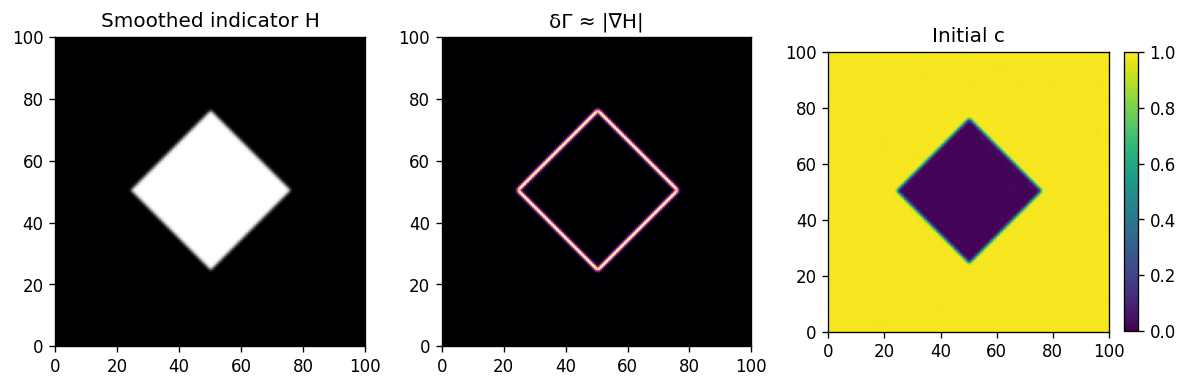

In [4]:
# -------------- Geometry & smoothed boundary --------------

def make_grid_mask(num_facets=4, r_electrode=70, center=None):
    cx = nx//2 if center is None else center[0]
    cy = ny//2 if center is None else center[1]
    Xc = (np.arange(nx) - cx)
    Yc = (np.arange(ny) - cy)
    XX, YY = np.meshgrid(Xc, Yc, indexing='ij')
    if num_facets == 4:
        mask = (np.abs(XX) + np.abs(YY)) <= r_electrode
    elif num_facets == 6:
        s3o2 = np.sqrt(3)/2
        ax = np.abs(XX); ay = np.abs(YY)
        mask = np.maximum(ay, s3o2*ax + 0.5*ay) <= r_electrode
    else:
        mask = (XX**2 + YY**2) <= r_electrode**2
    return mask.astype(float)


def gaussian_filter(f, sigma):
    Fk = fftn(f)
    g = np.exp(-0.5 * ((KX*sigma)**2 + (KY*sigma)**2))
    return np.real(ifftn(Fk*g))


def grad(f):
    fk = fftn(f)
    dfx = np.real(ifftn(1j*KX*fk))
    dfy = np.real(ifftn(1j*KY*fk))
    return dfx, dfy

mask = make_grid_mask(num_facets=4, r_electrode=50)
H_raw = mask
H = gaussian_filter(H_raw, sigma=1*dx)
Hx, Hy = grad(H)
delta_Gamma = np.sqrt(Hx**2 + Hy**2) + 1e-14

# Initial condition: particle (H=1) is Li-poor FP c~0; reservoir outside c=1
#c = 1.0 - H
#c += 1e-3*(np.random.rand(nx, ny)-0.5)

# Initial condition with stronger noise
c = 1.0 - H
c += 5e-2*(np.random.rand(nx, ny)-0.5)  # Increased from 1e-3
c = np.clip(c, 0.01, 0.99)

fig, axs = plt.subplots(1,3, figsize=(10,3.2))
extent = [0, Lx*1e9, 0, Ly*1e9]  # axes in nanometers

axs[0].imshow(H.T, origin='lower', cmap='gray',extent=extent); axs[0].set_title('Smoothed indicator H')
axs[1].imshow(delta_Gamma.T, origin='lower', cmap='magma', extent=extent); axs[1].set_title('δΓ ≈ |∇H|')
im = axs[2].imshow(c.T, origin='lower', vmin=0, vmax=1, extent=extent); axs[2].set_title('Initial c')
plt.colorbar(im, ax=axs[2], fraction=0.045)
plt.tight_layout(); plt.show()

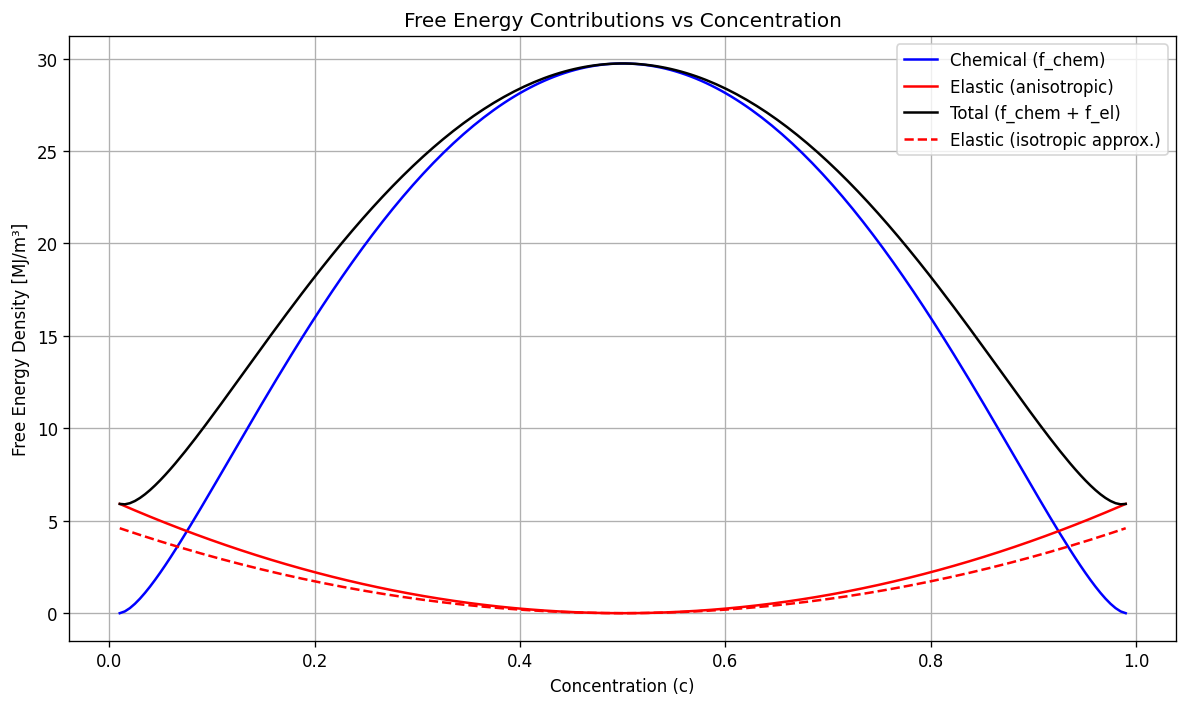

Energy at c=0: 5.912 MJ/m³
Energy at c=1: 5.912 MJ/m³
Energy at c=0.5: 29.737 MJ/m³
Maximum elastic contribution: 5.91e+06 J/m³
Chemical barrier height: 2.97e+07 J/m³
Total barrier height: 2.38e+07 J/m³

Elastic energy diagnostics:
E_Young = 134.2 GPa
Effective eigenstrain = 1.69%
Maximum elastic energy (isotropic) = 4.6 MJ/m³
Maximum elastic energy (anisotropic) = 5.9 MJ/m³

Chemical energy diagnostics:
RT/Vm = 56.6 MJ/m³
Interaction parameter omega/Vm = 274.0 MJ/m³
Maximum chemical energy = 29.7 MJ/m³


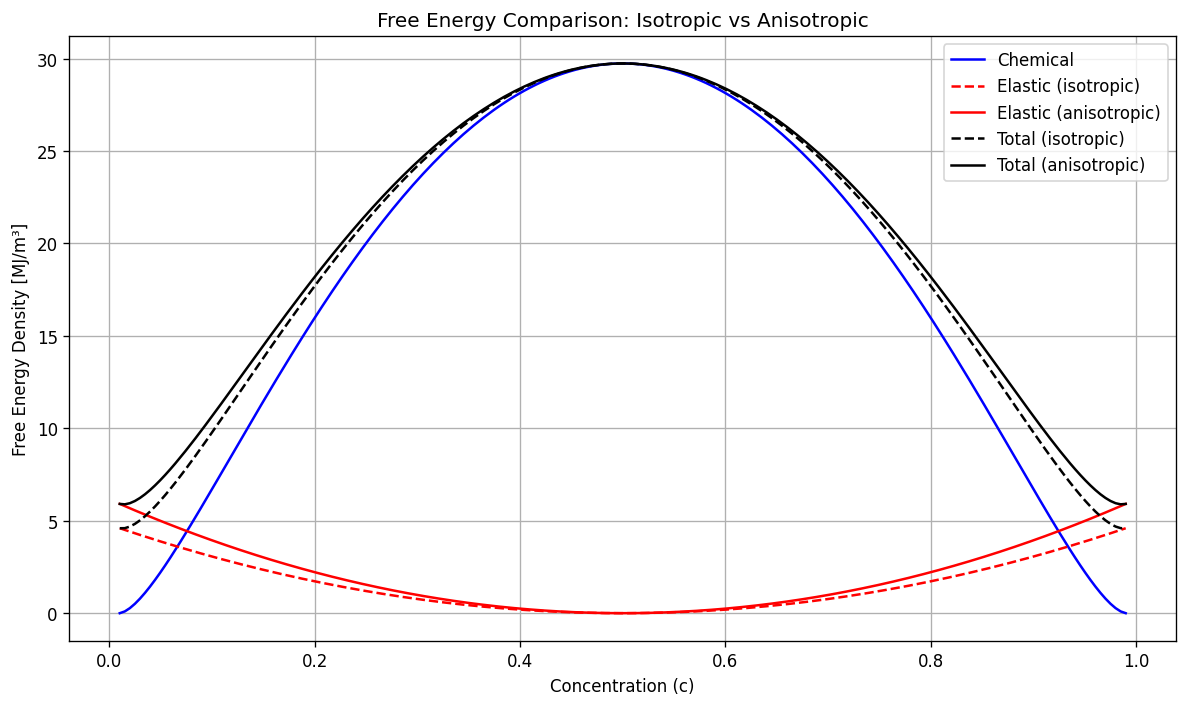


Energy comparison (isotropic vs anisotropic):
Max elastic (iso): 4.6 MJ/m³
Max elastic (aniso): 5.9 MJ/m³
Barrier height (iso): 25.1 MJ/m³
Barrier height (aniso): 23.8 MJ/m³


In [5]:
# ---------------- Elasticity (plane strain, anisotropic) ----------------
# Build 4th rank stiffness C_ijkl (2D) from Voigt (xx,yy,xy) for plane strain
# Base isotropic: lambda, mu -> C11=C22=lambda+2mu, C12=lambda, C66=mu

def isotropic_voigt(E, nu):
    lam = E*nu/((1+nu)*(1-2*nu))
    mu  = E/(2*(1+nu))
    C11 = lam + 2*mu
    C22 = C11
    C12 = lam
    C66 = mu
    return C11, C22, C12, C66

# Apply simple orthotropic scaling in crystal frame
C11_i, C22_i, C12_i, C66_i = isotropic_voigt(E_base, nu_base)
C11_c = C11_i * anisotropy_scale_x
C22_c = C22_i * anisotropy_scale_y
C12_c = C12_i
C66_c = C66_i * (0.5*(anisotropy_scale_x+anisotropy_scale_y))  # mild shear adjustment

# Build C (2,2,2,2) in crystal frame
C_c = np.zeros((2,2,2,2))
C_c[0,0,0,0] = C11_c
C_c[1,1,1,1] = C22_c
C_c[0,0,1,1] = C12_c
C_c[1,1,0,0] = C12_c
C_c[0,1,0,1] = C66_c
C_c[1,0,1,0] = C66_c
C_c[0,1,1,0] = C66_c
C_c[1,0,0,1] = C66_c

# Rotation (crystal -> lab)
def rot2(theta):
    c = np.cos(theta); s = np.sin(theta)
    return np.array([[c,-s],[s,c]])

A = rot2(crystal_theta)
# C_lab(i,j,k,l) = a_iα a_jβ a_kγ a_lδ C_c(α,β,γ,δ)
C_lab = np.einsum('ia,jb,kc,ld,abcd->ijkl', A, A, A, A, C_c)

# Eigenstrain star in crystal frame (principal)
Estar_c = np.array([[eps_star_xx, 0.0],[0.0, eps_star_yy]])
# Rotate to lab once (constant)
Estar_lab = A @ Estar_c @ A.T

# Spectral microelasticity solver
# Given eigenstrain field E0(x) = (1-c) * Estar_lab, homogeneous C_lab.
# Solve in Fourier: A_il u_l = i k_j C_ijkl E0_kl, with A_il = k_j C_ijkl k_k

# Precompute A(k) inverse across grid
kx = KX; ky = KY
K = Kstack  # (...,2)
C = C_lab
A_mat = np.einsum('...j,ijkl,...k->...il', K, C, K)   # (nx,ny,2,2)
# Handle k=0 separately to avoid singularity
A11 = A_mat[...,0,0]; A12 = A_mat[...,0,1]; A21 = A_mat[...,1,0]; A22 = A_mat[...,1,1]
detA = A11*A22 - A12*A21
# Regularize det at k=0
mask_k0 = (np.abs(kx)<1e-14) & (np.abs(ky)<1e-14)
detA[mask_k0] = 1.0
invA = np.empty_like(A_mat)
invA[...,0,0] =  A22/detA
invA[...,0,1] = -A12/detA
invA[...,1,0] = -A21/detA
invA[...,1,1] =  A11/detA



def solve_elastic_fields(c):
    # Reference concentration should be c0=0.5
    c0 = 0.5

    # Modified eigenstrain field relative to reference state
    # E0 = (c-c0)*Estar to make energy minimum at c=c0
    E0_xx = (c - c0) * Estar_lab[0,0]
    E0_xy = (c - c0) * Estar_lab[0,1]
    E0_yy = (c - c0) * Estar_lab[1,1]

    # Pack into tensor
    E0 = np.zeros((nx,ny,2,2))
    E0[...,0,0] = E0_xx
    E0[...,0,1] = E0_xy
    E0[...,1,0] = E0_xy
    E0[...,1,1] = E0_yy

    # Fourier of eigenstrain
    E0k = np.zeros_like(E0, dtype=complex)
    E0k[...,0,0] = fftn(E0[...,0,0])
    E0k[...,0,1] = fftn(E0[...,0,1])
    E0k[...,1,0] = fftn(E0[...,1,0])
    E0k[...,1,1] = fftn(E0[...,1,1])

    # RHS b_i = i k_j C_ijkl E0_kl
    b = 1j * np.einsum('...j,ijkl,...kl->...i', K, C, E0k)
    # Solve u = invA * b for each k (with k=0 => u=0)
    u_k = np.einsum('...ij,...j->...i', invA, b)
    u_k[mask_k0,...] = 0.0

    # Strain in Fourier: ε_kl = 0.5j * (k_k u_l + k_l u_k)
    Ux = u_k[...,0]; Uy = u_k[...,1]
    Exx_k = 1j * KX * Ux
    Eyy_k = 1j * KY * Uy
    Exy_k = 0.5j * (KX * Uy + KY * Ux)

    # Back to real
    Exx = np.real(ifftn(Exx_k))
    Eyy = np.real(ifftn(Eyy_k))
    Exy = np.real(ifftn(Exy_k))

    # Stress: σ = C : (ε - ε0)
    # pack eps- E0
    dE = np.zeros_like(E0)
    dE[...,0,0] = Exx - E0[...,0,0]
    dE[...,0,1] = Exy - E0[...,0,1]
    dE[...,1,0] = Exy - E0[...,1,0]
    dE[...,1,1] = Eyy - E0[...,1,1]

    sigma = np.einsum('ijkl,...kl->...ij', C, dE)

    # Elastic energy density (should be quadratic around c0)
    f_el = 0.5 * np.einsum('...ij,ijkl,...kl', dE, C, dE)

    # Chemical potential from elastic contribution
    mu_el = (sigma[...,0,0]*Estar_lab[0,0] +
             2*sigma[...,0,1]*Estar_lab[0,1] +
             sigma[...,1,1]*Estar_lab[1,1])
    # Diagnostics: strain/stress magnitudes
    strain_mag = np.sqrt(Exx**2 + Eyy**2 + 2*Exy**2)
    von_mises = np.sqrt( (sigma[...,0,0]-sigma[...,1,1])**2 + 3*(2*sigma[...,0,1])**2 )

    return mu_el, f_el, (Exx,Eyy,Exy), (sigma[...,0,0], sigma[...,1,1], sigma[...,0,1]), strain_mag, von_mises

def plot_free_energy_comparison():
    """Plot chemical and elastic contributions to mixing free energy"""
    # Concentration grid
    c = np.linspace(0.01, 0.99, 200)

    # Chemical free energy (from FE class)
    f_chem = FE.f(c)

    # Get elastic energy by calling solve_elastic_fields for each concentration
    f_el = np.zeros_like(c)
    for i, ci in enumerate(c):
        c_field = ci * np.ones((nx, ny))
        _, f_el_i, *_ = solve_elastic_fields(c_field)  # Unpack only the first two, ignore the rest
        f_el[i] = f_el_i[nx//2, ny//2]
    #for i, ci in enumerate(c):
    #    # Make uniform concentration field
    #    c_field = ci * np.ones((nx, ny))
    #    _, f_el_i, _, _, _, _ = solve_elastic_fields(c_field)
    #    # Take center point (or average) as representative value
    #    f_el[i] = f_el_i[nx//2, ny//2]

    # Shift chemical energy to zero minimum
    f_chem -= np.min(f_chem)

    # Total energy
    f_total = f_chem + f_el

    # Plotting with scientific notation
    plt.figure(figsize=(10,6))
    plt.plot(c, f_chem/1e6, 'b-', label='Chemical (f_chem)')
    plt.plot(c, f_el/1e6, 'r-', label='Elastic (anisotropic)')
    plt.plot(c, f_total/1e6, 'k-', label='Total (f_chem + f_el)')

    # For comparison, plot isotropic approximation
    E_Young = E_base/(1-nu_base**2)
    eps_eff = np.sqrt(eps_star_xx**2 + eps_star_yy**2)
    f_el_iso = 0.5 * E_Young * eps_eff**2 * (c - 0.5)**2
    plt.plot(c, f_el_iso/1e6, 'r--', label='Elastic (isotropic approx.)')

    plt.xlabel('Concentration (c)')
    plt.ylabel('Free Energy Density [MJ/m³]')
    plt.title('Free Energy Contributions vs Concentration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print diagnostics
    print(f"Energy at c=0: {f_total[0]/1e6:.3f} MJ/m³")
    print(f"Energy at c=1: {f_total[-1]/1e6:.3f} MJ/m³")
    print(f"Energy at c=0.5: {f_total[100]/1e6:.3f} MJ/m³")  # Should be minimum
    print(f"Maximum elastic contribution: {np.max(f_el):.2e} J/m³")
    print(f"Chemical barrier height: {np.max(f_chem) - np.min(f_chem):.2e} J/m³")
    print(f"Total barrier height: {np.max(f_total) - np.min(f_total):.2e} J/m³")


     # Add diagnostic prints
    print("\nElastic energy diagnostics:")
    print(f"E_Young = {E_Young/1e9:.1f} GPa")
    print(f"Effective eigenstrain = {eps_eff*100:.2f}%")
    print(f"Maximum elastic energy (isotropic) = {f_el_iso.max()/1e6:.1f} MJ/m³")
    print(f"Maximum elastic energy (anisotropic) = {f_el.max()/1e6:.1f} MJ/m³")

    # Chemical energy scale
    print("\nChemical energy diagnostics:")
    print(f"RT/Vm = {(R*T/Vm)/1e6:.1f} MJ/m³")
    print(f"Interaction parameter omega/Vm = {(omega/Vm)/1e6:.1f} MJ/m³")
    print(f"Maximum chemical energy = {f_chem.max()/1e6:.1f} MJ/m³")
plot_free_energy_comparison()

# Then add comparison plot showing both cases:
def plot_energy_comparison_iso_aniso():
    """Compare isotropic vs anisotropic elastic energy contributions"""
    c = np.linspace(0.01, 0.99, 200)
    f_chem = FE.f(c)
    f_chem -= np.min(f_chem)

    # Isotropic approximation
    E_Young = E_base/(1-nu_base**2)
    eps_eff = np.sqrt(eps_star_xx**2 + eps_star_yy**2)
    f_el_iso = 0.5 * E_Young * eps_eff**2 * (c - 0.5)**2
    f_total_iso = f_chem + f_el_iso

    # Full anisotropic solution
    f_el_aniso = np.zeros_like(c)
    for i, ci in enumerate(c):
        c_field = ci * np.ones((nx, ny))
        _, f_el_i, *_ = solve_elastic_fields(c_field)
        f_el_aniso[i] = f_el_i[nx//2, ny//2]
    #for i, ci in enumerate(c):
    #    c_field = ci * np.ones((nx, ny))
    #    _, f_el_i, _, _, _, _ = solve_elastic_fields(c_field)
     #   f_el_aniso[i] = f_el_i[nx//2, ny//2]
    f_total_aniso = f_chem + f_el_aniso

    plt.figure(figsize=(10,6))
    plt.plot(c, f_chem/1e6, 'b-', label='Chemical')
    plt.plot(c, f_el_iso/1e6, 'r--', label='Elastic (isotropic)')
    plt.plot(c, f_el_aniso/1e6, 'r-', label='Elastic (anisotropic)')
    plt.plot(c, f_total_iso/1e6, 'k--', label='Total (isotropic)')
    plt.plot(c, f_total_aniso/1e6, 'k-', label='Total (anisotropic)')

    plt.xlabel('Concentration (c)')
    plt.ylabel('Free Energy Density [MJ/m³]')
    plt.title('Free Energy Comparison: Isotropic vs Anisotropic')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print comparison
    print("\nEnergy comparison (isotropic vs anisotropic):")
    print(f"Max elastic (iso): {np.max(f_el_iso)/1e6:.1f} MJ/m³")
    print(f"Max elastic (aniso): {np.max(f_el_aniso)/1e6:.1f} MJ/m³")
    print(f"Barrier height (iso): {(np.max(f_total_iso)-np.min(f_total_iso))/1e6:.1f} MJ/m³")
    print(f"Barrier height (aniso): {(np.max(f_total_aniso)-np.min(f_total_aniso))/1e6:.1f} MJ/m³")

plot_energy_comparison_iso_aniso()

In [6]:
# ---------------- Operators, kinetics, and CH step ----------------

def laplace(f):
    fk = fftn(f)
    return np.real(ifftn(-K2 * fk))


def free_energy_mu_chem(c):
    return FE.dfdc(c) - kappa * laplace(c)


def mobility(c):
    # diffuse only inside particle (H~1); suppress outside (reservoir)
    return M0 * (H * c * (1 - c))


def eta_from_mu(mu, DeltaPhi):
    # η = μ_eq - μ - F ΔΦ  (J/m^3)
    # Convert from J/m³ to J/mol before dividing by F
    return (mu_eq_val - mu)*Vm - F*DeltaPhi


def J_BV(eta):
    scale = (R*T)/Vm
    return j0_BV * (np.exp(alpha*eta/scale) - np.exp(-(1-alpha)*eta/scale))


def J_MHC(eta):
    # Simplified symmetric curved-Tafel (saturating) variant; exact Zeng et al. can replace later.
    scale = (R*T)/Vm
    et = eta/scale
    lam_t = (lambda_MHC/(R*T))
    denom = np.maximum(4.0*lam_t, 1e-12)
    j = j0_MHC*( np.exp(-((lam_t - et)**2)/denom) - np.exp(-((lam_t + et)**2)/denom) ) + s_corr
    return j


def divergence_of_M_grad_mu(Mc, mu):
    muk = fftn(mu)
    mux = np.real(ifftn(1j*KX*muk))
    muy = np.real(ifftn(1j*KY*muk))
    jx = Mc * mux
    jy = Mc * muy
    jkx = fftn(jx)
    jky = fftn(jy)
    return np.real(ifftn(1j*KX*jkx + 1j*KY*jky))

# Semi-implicit stabilizer for ∇^4 part (use constant Mlin)
Mlin = M0
A_k = 1.0 + dt * Mlin * kappa * (K2**2)


def step_CH(c, kinetics='BV'):
    # chemical + elastic μ
    mu_chem = free_energy_mu_chem(c)
    mu_el, f_el, strains, stresses, strain_mag, vm = solve_elastic_fields(c)
    mu = mu_chem + mu_el

    # Interfacial current density and volumetric source
    eta = eta_from_mu(mu, DeltaPhi)
    J = J_BV(eta) if kinetics=='BV' else J_MHC(eta)
    Rsrc = (Vm/(F*L_if)) * J * delta_Gamma

    # CH update
    Mc = mobility(c)
    div_term = divergence_of_M_grad_mu(Mc, mu)
    rhs = c + dt*(div_term + Rsrc)
    c_new = np.real(ifftn(fftn(rhs)/A_k))
    # enforce reservoir outside
    c_new = H*c_new + (1-H)*1.0
    c_new = np.clip(c_new, 1e-8, 1-1e-8)
    return c_new, mu, mu_el, f_el, strains, stresses, strain_mag, vm, J



def step_CH_convex(c, kinetics='BV'):
    """Convex splitting scheme with improved Newton solver"""
    # Split chemical potential into convex/concave parts
    mu_rs = omega * (1 - 2*c)/Vm  # regular solution
    mu_el, f_el, strains, stresses, strain_mag, vm = solve_elastic_fields(c)
    mu_explicit = mu_rs + mu_el

    def ideal_mu(c):
        ce = np.clip(c, 1e-12, 1-1e-12)
        return (R*T/Vm) * (np.log(ce) - np.log(1-ce))

    def M_stable(c):
        return M0 * H * np.minimum(c*(1-c), 0.25)

    Mc = M_stable(c)

    # Improved Newton solver with relaxation
    def newton_step(c_old, c_guess):
        dc = 1e-8
        f1 = ideal_mu(c_guess + dc)
        f0 = ideal_mu(c_guess)
        dmu_dc = (f1 - f0)/dc

        mu_total = ideal_mu(c_guess) + mu_explicit - kappa*laplace(c_guess)
        div_term = divergence_of_M_grad_mu(Mc, mu_total)

        residual = c_guess - c_old - dt*div_term
        update = residual/(1 + dt*Mc*dmu_dc)

        # Add relaxation
        return c_guess - omega_newton * update

    # Newton iteration with convergence check
    c_new = c.copy()
    for i in range(max_newton):
        c_prev = c_new.copy()
        c_new = newton_step(c, c_new)

        # Check convergence
        rel_change = np.max(np.abs(c_new - c_prev))
        if rel_change < 1e-6:
            break

        # Enforce bounds every iteration
        c_new = H*c_new + (1-H)*1.0
        c_new = np.clip(c_new, 1e-8, 1-1e-8)

    return c_new

def step_CH_adaptive(c, dt, kinetics='BV', tol=0.4):
    """Adaptive time stepping with improved stability"""
    dt_local = dt
    max_dt = 2.6e-5
    min_dt = 1e-12

    reduce_factor = 0.7    # Even gentler reduction
    increase_factor = 1.01  # More gradual increase

    init_relax = 0.5   # Stronger initial relaxation
    fail_relax = 0.3   # Stronger relaxation after failures

    max_attempts = 50  # Allow more attempts
    attempt = 0
    c_prev = c.copy()       # Initialize c_prev

    while attempt < max_attempts:
        try:
            attempt += 1

            # Stronger relaxation for early attempts
            if attempt > 1:
                c_relaxed = 0.7*c + 0.3*c_prev
            else:
                c_relaxed = c

            c_new = step_CH_convex(c_relaxed, kinetics)
            max_change = np.max(np.abs(c_new - c))

            if attempt % 5 == 0:
                print(f"  Attempt {attempt}: dt={dt_local:.2e}, max_change={max_change:.2e}")

            if max_change > tol:
                dt_local *= reduce_factor
                if dt_local < min_dt:
                    raise Exception(f"Time step {dt_local:.2e} too small")
                c_prev = c_new
                continue

            if max_change < 0.2*tol and dt_local < max_dt:
                dt_local = min(dt_local * increase_factor, max_dt)

            return c_new, dt_local

        except Exception as e:
            if attempt % 5 == 0:
                print(f"  Attempt {attempt} failed: {e}")
            dt_local *= reduce_factor
            if dt_local < min_dt:
                raise Exception("Time step too small")

    raise Exception("Failed to converge after maximum attempts")

def save_simulation_state(filename, c, dt_current, it):
    """Save current simulation state to NPZ file"""
    np.savez(filename,
             concentration=c,
             time_step=dt_current,
             iteration=it,
             mask=H,
             parameters=np.array([Vm, D, kappa, DeltaPhi]))  # Save key parameters
    print(f"Simulation state saved to {filename}")

def load_simulation_state(filename):
    """Load simulation state from NPZ file"""
    data = np.load(filename)
    c = data['concentration']
    dt_current = float(data['time_step'])
    it = int(data['iteration'])
    H = data['mask']

    # Verify parameters match
    Vm_saved, D_saved, kappa_saved, DeltaPhi_saved = data['parameters']
    if not np.allclose([Vm, D, kappa, DeltaPhi],
                      [Vm_saved, D_saved, kappa_saved, DeltaPhi_saved]):
        print("Warning: Saved parameters differ from current settings")

    return c, dt_current, it, H

In [ ]:
# ---------------- Run & visualize ----------------
#frames = []
#for it in range(1, nsteps+1):
#    c, mu, mu_el, f_el, strains, stresses, strain_mag, vm, J = step_CH(c, kinetics)
# Modified main loop with stabilization
frames = []
save_interval = 1000  # Save every 1000 steps
dt_current = dt  # Initial time step
from tqdm.notebook import tqdm
t_elapsed=0
print(f"Starting simulation with dt = {dt_current:.2e}")

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(c.T, origin='lower', vmin=0, vmax=1, extent=extent)
ax.set_title('Initial c at t=0')
ax.set_xlabel('x [nm]')
ax.set_ylabel('y [nm]')
axs[0,0].contour(H, levels=[0.5], colors='red', linewidths=1, origin='lower', extent=extent)
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

for it in tqdm(range(1, nsteps+1), desc='Simulating'):
    try:
        # Adaptive time stepping
        c_new, dt_current = step_CH_adaptive(c, dt_current, kinetics)
        # Save checkpoint
        if it % save_interval == 0:
            save_simulation_state(f'checkpoint_step_{it}.npz', c_new, dt_current, it)

        if it % 100 == 0:
            print(f"Step {it}: dt = {dt_current:.2e}")
        # Calculate fields for visualization
        mu_el, f_el, strains, stresses, strain_mag, vm = solve_elastic_fields(c_new)
        mu = free_energy_mu_chem(c_new) + mu_el
        eta = eta_from_mu(mu, DeltaPhi)
        J = J_BV(eta) if kinetics=='BV' else J_MHC(eta)
        t_elapsed=t_elapsed+dt_current
        c = c_new  # Update only after successful step

        if it % nplot == 0:
            fig, axs = plt.subplots(2,3, figsize=(10,6))
            im0 = axs[0,0].imshow(c.T, origin='lower', vmin=0, vmax=1, extent=extent); axs[0,0].set_title(f'c at t={t_elapsed:.3e}s')
            axs[0,0].contour(H, levels=[0.5], colors='red', linewidths=1, origin='lower', extent=extent)

            plt.colorbar(im0, ax=axs[0,0], fraction=0.046)
            im1 = axs[0,1].imshow(mu.T, origin='lower', extent=extent); axs[0,1].set_title('μ (chem+elastic) [J/m³]')
            plt.colorbar(im1, ax=axs[0,1], fraction=0.046)
            im2 = axs[0,2].imshow(mu_el.T, origin='lower', extent=extent); axs[0,2].set_title('μ_elastic [J/m³]')
            plt.colorbar(im2, ax=axs[0,2], fraction=0.046)

            Exx,Eyy,Exy = strains
            im3 = axs[1,0].imshow(strain_mag.T, origin='lower'); axs[1,0].set_title('|strain|')
            plt.colorbar(im3, ax=axs[1,0], fraction=0.046)
            sxx,syy,sxy = stresses
            im4 = axs[1,1].imshow(vm.T, origin='lower', extent=extent); axs[1,1].set_title('von Mises stress [Pa]')
            plt.colorbar(im4, ax=axs[1,1], fraction=0.046)
            im5 = axs[1,2].imshow(J.T, origin='lower', extent=extent); axs[1,2].set_title('Interfacial J [A/m²] (on δΓ)')
            plt.colorbar(im5, ax=axs[1,2], fraction=0.046)
            plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Error at step {it}: {e}")
        break
# Current and voltage proxies at final state
I_surface = (J * delta_Gamma).sum() * dx * dy
# Modified voltage proxy with proper reference and sign convention
V_ref = 3.45  # Reference voltage for LiFePO4 vs Li/Li+ (V)
V_proxy = V_ref + (mu.mean()*Vm/F - DeltaPhi)  # Note sign change on DeltaPhi
print(f"Surface current proxy I ≈ {I_surface:.3e} A")
print(f"Voltage proxy (μ/F + ΔΦ) ≈ {V_proxy:.4f} V")